# Longitudinal QuasiCopula GWAS

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots

# using MendelPlots
ENV["COLUMNS"] = 240

BLAS.set_num_threads(1)
Threads.nthreads()

# simulate PLINK data where each SNP has at least min_ma copies of the alt allele
function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
        p::Int64, mafs::Vector{Float64}; min_ma::Int = 1)
    all(0.0 .<= mafs .<= 0.5) || throw(ArgumentError("vector of minor allele frequencies must be in (0, 0.5)"))
#     any(mafs .<= 0.0005) && @warn("Provided minor allele frequencies contain entries smaller than 0.0005, simulation may take long if sample size is small and min_ma = $min_ma is large")

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = mafs[j]
        while minor_alleles <= min_ma
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end


# function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
#     p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

#     #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
#     A1 = BitArray(undef, n, p) 
#     A2 = BitArray(undef, n, p) 
#     for j in 1:p
#         minor_alleles = 0
#         maf = 0
#         while minor_alleles <= min_ma
#             maf = 0.5rand()
#             for i in 1:n
#                 A1[i, j] = rand(Bernoulli(maf))
#                 A2[i, j] = rand(Bernoulli(maf))
#             end
#             minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
#         end
#         mafs[j] = maf
#     end

#     #fill the SnpArray with the corresponding x_tmp entry
#     return _make_snparray(s, A1, A2)
# end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end

┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1342


_make_snparray (generic function with 1 method)

## Simulate data

In [77]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d_min = 1, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    maf = 0.5rand(),
    causal_snp_β = 0.5rand(),
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    Random.seed!(seed)
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
#     βtrue = [1.0; rand(-0.05:0.1:0.05, p-1)]
    βtrue = [1.0; rand(-0.5:1:0.5, p-1)]
#     βtrue = [1.0; rand(-5:10:5, p-1) .* rand(Uniform(0, 5), p-1)]
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)

    # simulate (nongenetic) design matrices
    Random.seed!(seed)
    X_full = Matrix{Float64}[]
    for i in 1:n
        nobs = rand(d_min:d_max) # number of obs for this sample
        push!(X_full, hcat(ones(nobs), randn(nobs, p - 1)))
    end
    
    # simulate causal alleles
    Random.seed!(seed)
    γtrue = zeros(q)
#     γtrue[1:k] .= rand([-0.2, 0.2], k)
    γtrue[1:k] .= causal_snp_β
    shuffle!(γtrue)
    
    # set minor allele freq
    mafs = fill(maf, q)
    
    # simulate random SnpArray with q SNPs with prespecified maf
    Random.seed!(seed)
    G = simulate_random_snparray(undef, n, q, mafs)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    
    # effect of causal alleles
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 10.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, size(X, 1))
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            vecd = Vector{DiscreteUnivariateDistribution}(undef, size(X, 1))
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs
maf = 0.3

qc_model, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d_min = 1, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 123,
    y_distribution = Normal,
    T = Float64,
    maf = maf,
    causal_snp_β = 0.2
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Normal
  * link function: IdentityLink
  * number of clusters: 5000
  * cluster size min, max: 1, 5
  * number of variance components: 2
  * number of fixed effects: 3



## Fit Null model

In [82]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 1000,
        accept_after_max_steps = 10,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="first-order"
    )
);

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [83]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

βtrue = [1.0, 0.5, -0.5]
qc_model.β = [0.9968009900007787, 0.4997214434275559, -0.4958451981871609]
qc_model.∇β = [-2.5856932772683194e-7, -1.7989225664649666e-8, 2.1988076603918216e-7]
θtrue = [0.1, 0.1]
qc_model.θ = [0.10150376115439251, 0.08139907616669381]
qc_model.∇θ = [-3.686933536251047e-9, 5.845502570878125e-8]


## Score tests

In [89]:
# mathematical
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

 37.137728 seconds (544.56 M allocations: 49.993 GiB, 10.20% gc time)


1000-element Vector{Float64}:
 0.8237296975660686
 0.7914769287992203
 0.8580527617643264
 0.179052026836582
 0.6336206119167219
 0.5734988821412844
 0.6396924534745424
 0.9144742102696328
 0.37079150766201363
 0.8691014427399351
 0.42649919215605037
 0.8417774798168322
 0.5830217800818045
 ⋮
 0.5190134434588909
 0.07561623259211413
 0.556516265020054
 0.6903774979357373
 0.9955222023803137
 0.8291027334509073
 0.649222997289102
 0.9820674454637706
 0.8038314336668764
 0.6250735901612189
 0.8892951046773175
 0.5603091578992931

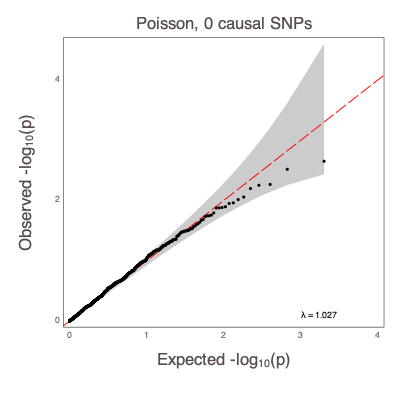

In [57]:
qq(pvals, dpi=80, titles="Poisson, $k causal SNPs")
display("image/png", read("qqplot.png"))

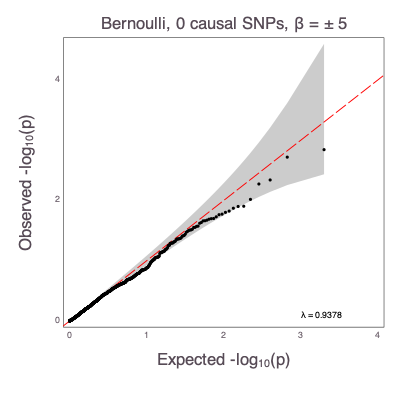

In [44]:
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs, β = ± 5")
display("image/png", read("qqplot.png"))

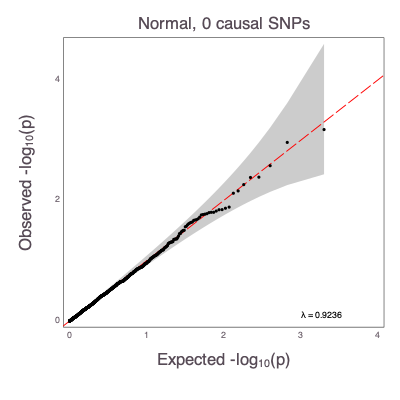

In [90]:
qq(pvals, dpi=80, titles="Normal, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [88]:
# autodiff gaussian
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

 23.246818 seconds (51.56 k allocations: 47.448 MiB)


1000-element Vector{Float64}:
 0.8236813989227758
 0.7914648766049942
 0.8580031000860484
 0.17840247475798485
 0.6335502506882558
 0.5732266202456917
 0.6394759854978589
 0.914432449089547
 0.37027308909327283
 0.8690498259952886
 0.42608656362745967
 0.8416995593165253
 0.5828069491437499
 ⋮
 0.518838210174124
 0.07536476091880122
 0.5560619046039359
 0.6901855216506115
 0.9955208707516241
 0.8290556689610323
 0.649169296189305
 0.9820603943005775
 0.8037819155694181
 0.6247261876391478
 0.8891846032812594
 0.5600459639368013

 26.755834 seconds (13.59 M allocations: 755.684 MiB, 0.44% gc time, 12.46% compilation time)


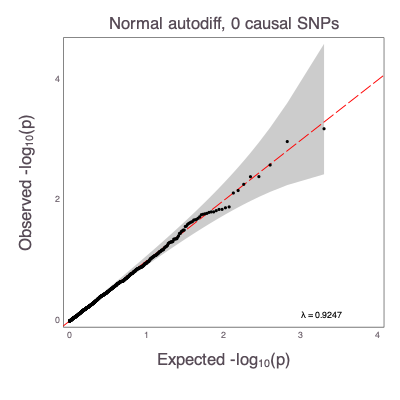

In [87]:
# check Gaussian using autodiff: it includes tau in grad/Hess -> not very different to excluding tau
qq(pvals, dpi=80, titles="Normal autodiff, $k causal SNPs")
display("image/png", read("qqplot.png"))

## Compare to autodiff

In [75]:
# autodiff
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

R = -101.14440349755202
Q = 17600.001868190935
W = [-258.580910668583, -346.17646848777446, 422.52520418804016, -110.15264349211672, -48.30807453426186]
R = -59.8375253568556
Q = 17431.73643731378
W = [-78.08279352281511, -58.902249635208264, -107.75344869352278, 161.37783396035306, 46.068201679120044]
R = -63.63008530687124
Q = 17526.1095230156
W = [-514.9026653748115, -1139.5271606057, 807.3713184437148, -180.4955370118778, 7.698848510798069]


LoadError: UndefVarError: fdsa not defined

In [76]:
# mathematical
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

R = -101.14440349755152
Q = 17600.001868190877
W = [-258.5809106685867, -346.1764684877716, 422.52520418803874, -110.15264349211664, -48.30807453426182]
R = -59.83752535685597
Q = 17431.736437313775
W = [-78.08279352281518, -58.90224963520853, -107.75344869352236, 161.3778339603536, 46.068201679120094]
R = -63.6300853068713
Q = 17526.109523015588
W = [-514.9026653748115, -1139.5271606057, 807.3713184437086, -180.4955370118775, 7.698848510798014]


LoadError: UndefVarError: fdsa not defined